In [ ]:
import pandas as pd
import numpy as np
import random,os
import torch.utils.data as Data
from sklearn.metrics import f1_score,recall_score,precision_score,roc_curve,auc,accuracy_score,confusion_matrix,r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import torch
# import torch.nn as nn
from torch import nn,optim
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer, required
import gc
import time
import math
import matplotlib.pyplot as plt

In [ ]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''



class BasicBlock(nn.Module):
    expansion = 1

        def __init__(self, in_planes, planes, stride=2):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_planes, planes, kernel_size=5, stride=stride, padding=2, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        x1 = self.shortcut(x)
        if x1.shape[-1] != out.shape[-1]:
            x1 = x1[:, :, :out.shape[-1]]
        out += x1
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv1d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.conv3 = nn.Conv1d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm1d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=5):
        super(ResNet, self).__init__()
        self.input_channel = 1
        self.in_planes = 64

        self.conv1 = nn.Conv1d(self.input_channel, self.in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(self.in_planes)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=2)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)
        self.dropout = nn.Dropout(0.2)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool1d(out, 1).view(out.size(0), -1)
        out = self.dropout(out)
        out = self.linear(out)
        return out

    def reg_loss(self):
        reg_loss = 0.0
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv1d):
                reg_loss += torch.sum(torch.abs(m.weight))
        return reg_loss

    def l1reg_loss(self):
        reg_loss = 0.0
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv1d):
                reg_loss += torch.sum(torch.abs(m.weight))
        return reg_loss

    def l12reg_loss(self):
        reg_loss = 0.0
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv1d):
                reg_loss += torch.sum((torch.abs(m.weight) + 1e-6).sqrt())
        return reg_loss

    def l23reg_loss(self):
        reg_loss = 0.0
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv1d):
                reg_loss += torch.sum((torch.abs(m.weight) + 1e-6).pow(2 / 3))
        return reg_loss

    def exact_sparsity(self):
        nnz = 0
        total_param = 0.0
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv1d):
                total_param += np.prod(m.weight.data.shape)
                nnz += torch.sum(m.weight.data != 0).detach().item()
        ratio = nnz / total_param
        return ratio

    def sparsity_level(self):
        nnz_2 = 0.0
        nnz_3 = 0.0
        nnz_4 = 0.0
        total_param = 0.0
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv1d):
                total_param += np.prod(m.weight.data.shape)
                nnz_2 += torch.sum(m.weight.data.abs() >= 0.01).detach().item()
                nnz_3 += torch.sum(m.weight.data.abs() >= 0.001).detach().item()
                nnz_4 += torch.sum(m.weight.data.abs() >= 0.0001).detach().item()
        ratio_2 = nnz_2 / total_param
        ratio_3 = nnz_3 / total_param
        ratio_4 = nnz_4 / total_param
        return ratio_2, ratio_3

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])

def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 1, 1000))  # Example input for 1D genomic data with 1000 features
    print(y.size())


In [ ]:
net = ResNet18()
net(torch.rand([35,1,529,529]))

1 torch.Size([35, 64, 263, 263])
2 torch.Size([35, 64, 131, 131])
3 torch.Size([35, 64, 131, 131])
1 torch.Size([35, 64, 129, 129])
2 torch.Size([35, 64, 127, 127])
3 torch.Size([35, 64, 127, 127])
1 torch.Size([35, 128, 63, 63])
2 torch.Size([35, 128, 31, 31])
3 torch.Size([35, 128, 31, 31])
1 torch.Size([35, 128, 29, 29])
2 torch.Size([35, 128, 27, 27])
3 torch.Size([35, 128, 27, 27])
1 torch.Size([35, 256, 13, 13])
2 torch.Size([35, 256, 6, 6])
3 torch.Size([35, 256, 6, 6])
1 torch.Size([35, 256, 4, 4])
2 torch.Size([35, 256, 2, 2])
3 torch.Size([35, 256, 2, 2])


tensor([[ 6.0897e-01,  3.4467e-01,  1.4449e+00,  1.3051e-01, -3.9126e-01],
        [ 6.1392e-01, -2.9817e-01,  2.2365e+00, -7.5860e-01, -4.7162e-01],
        [ 1.4457e-01, -7.9887e-01,  3.5700e-01, -2.2242e-02,  1.0272e+00],
        [ 4.9928e-01, -1.1885e+00,  1.6506e+00, -4.1080e-01, -2.3591e-01],
        [ 7.5289e-02, -1.4801e+00,  1.6055e+00, -1.9498e-01,  1.1269e+00],
        [ 7.9856e-01, -3.9796e-01,  1.8062e+00, -3.6544e-01,  5.9264e-01],
        [ 1.2730e+00, -5.9346e-01,  2.9772e-01, -2.0840e-01, -7.4229e-02],
        [ 3.0167e-01, -1.3968e+00,  1.8140e+00,  3.3971e-01,  1.2598e+00],
        [ 1.2760e+00, -5.6288e-01,  8.1168e-01, -8.6617e-01,  2.2294e-01],
        [-5.8046e-01, -9.0921e-01,  1.5764e+00, -1.2824e+00,  3.0161e-01],
        [ 3.8200e-01, -1.3019e+00,  5.2936e-01, -8.9636e-01,  1.5326e+00],
        [ 6.4161e-01, -2.2584e-01,  2.0175e+00, -2.5758e-01,  9.9670e-01],
        [ 9.8744e-01,  3.0334e-02,  1.4274e+00, -1.0625e-01,  2.8331e-01],
        [ 9.9430e-01, -1.

In [ ]:
path1='/root/ResNet/'
path_name = os.path.join(path1,'pig_data.csv')
df = pd.read_csv(path_name,header=None)
df

/tmp/ipykernel_27884/1669737403.py:3: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_name,header=None)


,0,1,2,3,4,5,6,7,8,9,...,52839,52840,52841,52842,52843,52844,52845,52846,52847,52848
0,ID,t1,t2,t3,t4,t5,1.0,2.0,3.0,4.0,...,52834.0,52835.0,52836.0,52837.0,52838.0,52839.0,52840.0,52841.0,52842.0,52843.0
1,1136,-0.8687035,0.28158495,1.71659645,-0.8861064,47.6114438,1.0,2.0,1.0,2.0,...,2.0,1.0,1.0,2.0,1.0,1.0,0.0,2.0,0.0,1.0
2,1318,0.13144417,-1.7468354,0.95272593,0.15843581,-41.940212,1.0,2.0,1.0,0.0,...,0.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0
3,1319,-0.8536013,-2.9968045,-0.0871332,-1.2177578,100.653792,1.0,2.0,1.0,1.0,...,0.0,1.0,1.0,2.0,0.0,2.0,1.0,2.0,1.0,2.0
4,1321,0.03416785,-0.320321,-0.071189,-1.4672803,13.8808255,1.0,2.0,0.0,0.0,...,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2310,6466,0.045294,1.386794,2.291255,0.226449,-23.831346,0.0,1.0,2.0,1.0,...,0.0,0.0,1.0,0.0,2.0,2.0,0.0,2.0,1.0,2.0
2311,6467,-1.199029,-0.565144,2.225259,-5.672833,85.793067,1.0,2.0,1.0,2.0,...,1.0,1.0,2.0,0.0,0.0,2.0,0.0,2.0,2.0,2.0
2312,6469,-0.964449,0.673534,1.754374,-1.489569,-8.871632,2.0,2.0,2.0,1.0,...,0.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,0.0
2313,6471,-0.832078,-1.40681,2.368887,-1.517962,51.492272,1.0,1.0,2.0,1.0,...,1.0,1.0,2.0,1.0,1.0,2.0,0.0,2.0,0.0,2.0


In [ ]:
df.columns = df.iloc[0,:]
df = df.iloc[1:,:]
df.index = range(len(df))
df

,ID,t1,t2,t3,t4,t5,1.0,2.0,3.0,4.0,...,52834.0,52835.0,52836.0,52837.0,52838.0,52839.0,52840.0,52841.0,52842.0,52843.0
0,1136,-0.8687035,0.28158495,1.71659645,-0.8861064,47.6114438,1.0,2.0,1.0,2.0,...,2.0,1.0,1.0,2.0,1.0,1.0,0.0,2.0,0.0,1.0
1,1318,0.13144417,-1.7468354,0.95272593,0.15843581,-41.940212,1.0,2.0,1.0,0.0,...,0.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0
2,1319,-0.8536013,-2.9968045,-0.0871332,-1.2177578,100.653792,1.0,2.0,1.0,1.0,...,0.0,1.0,1.0,2.0,0.0,2.0,1.0,2.0,1.0,2.0
3,1321,0.03416785,-0.320321,-0.071189,-1.4672803,13.8808255,1.0,2.0,0.0,0.0,...,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0
4,1322,0.57391141,-2.0458374,0.054743,0.16402708,-58.738674,2.0,2.0,1.0,1.0,...,0.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2309,6466,0.045294,1.386794,2.291255,0.226449,-23.831346,0.0,1.0,2.0,1.0,...,0.0,0.0,1.0,0.0,2.0,2.0,0.0,2.0,1.0,2.0
2310,6467,-1.199029,-0.565144,2.225259,-5.672833,85.793067,1.0,2.0,1.0,2.0,...,1.0,1.0,2.0,0.0,0.0,2.0,0.0,2.0,2.0,2.0
2311,6469,-0.964449,0.673534,1.754374,-1.489569,-8.871632,2.0,2.0,2.0,1.0,...,0.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,0.0
2312,6471,-0.832078,-1.40681,2.368887,-1.517962,51.492272,1.0,1.0,2.0,1.0,...,1.0,1.0,2.0,1.0,1.0,2.0,0.0,2.0,0.0,2.0


In [ ]:
X = df.iloc[:,6:]
Y = df.iloc[:,1:6]
Y

,t1,t2,t3,t4,t5
0,-0.8687035,0.28158495,1.71659645,-0.8861064,47.6114438
1,0.13144417,-1.7468354,0.95272593,0.15843581,-41.940212
2,-0.8536013,-2.9968045,-0.0871332,-1.2177578,100.653792
3,0.03416785,-0.320321,-0.071189,-1.4672803,13.8808255
4,0.57391141,-2.0458374,0.054743,0.16402708,-58.738674
...,...,...,...,...,...
2309,0.045294,1.386794,2.291255,0.226449,-23.831346
2310,-1.199029,-0.565144,2.225259,-5.672833,85.793067
2311,-0.964449,0.673534,1.754374,-1.489569,-8.871632
2312,-0.832078,-1.40681,2.368887,-1.517962,51.492272


In [ ]:
Y = Y.astype('float')

In [ ]:
from sklearn.preprocessing import OneHotEncoder


# 初始化OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# 选择要进行独热编码的列
cols_to_encode = df.columns[6:]

# 拟合训练集
encoder.fit(X)

# 对训练集和测试集进行转换
X_encoded = encoder.transform(X)


/root/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
X_encoded.shape

(2314, 279995)

In [ ]:
import numpy as np

# 假设data是一个形状为(2314, 279995)的数组
# 裁剪数据以使列数为279841
data_trimmed = X_encoded[:, :279841]

# 重塑数据为(2314, 529, 529)
data_reshaped = data_trimmed.reshape(2314,1, 529, 529)




In [ ]:

# # 假设data是一个形状为(N, 30987)的数组
# padding = np.zeros((X_encoded.shape[0], 31329 - X_encoded.shape[1]))
# data_padded = np.concatenate([X_encoded, padding], axis=1)
# # 然后，将数据重塑为(n, 177, 177, 1)
# data_reshaped = data_padded.reshape(-1, 1,177, 177)
# data_reshaped.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data_reshaped,Y , test_size=0.2, random_state=42)

In [ ]:
def z_score(data):
    data = data.astype(float)
    Mean = data.mean()
    Var = ((data - Mean)**2).mean()
    Std = pow(Var,0.5)
    data = (data - Mean)/Std  # 标准化
    return Mean,Std,data
Mean,Std,Y_train = z_score(Y_train)
Y_test = (Y_test - Mean)/Std

In [ ]:
Y_train = Y_train.values
Y_test = Y_test.values

In [ ]:
Y_train = np.squeeze(Y_train)
Y_test = np.squeeze(Y_test)

X_train = torch.tensor(X_train,dtype = torch.float)
Y_train  = torch.tensor(Y_train,dtype = torch.float)

X_test = torch.tensor(X_test,dtype = torch.float)
Y_test  = torch.tensor(Y_test,dtype = torch.float)
print(X_train.shape, Y_train.shape,X_test.shape, Y_test.shape)

torch.Size([1851, 1, 529, 529]) torch.Size([1851, 5]) torch.Size([463, 1, 529, 529]) torch.Size([463, 5])


In [ ]:
train_loader = Data.DataLoader(
    dataset=Data.TensorDataset(X_train, Y_train),  # 封装进Data.TensorDataset()类的数据，可以为任意维度
    batch_size=35,  # 每块的大小
    shuffle=True,
    drop_last =True, #丢弃最后一组数据
    num_workers=0,  # 多进程（multiprocess）来读数据
)
test_loader = Data.DataLoader(
    dataset=Data.TensorDataset(X_test, Y_test),  # 封装进Data.TensorDataset()类的数据，可以为任意维度
    batch_size=35,  # 每块的大小
    shuffle=False,
    drop_last =True,
    num_workers=0,
)

In [ ]:
class AdamL12(Optimizer):
    r""" Implements Adam with L0 regularization

    A General Family of Proximal Methods for Stochastic Preconditioned Gradient Descent

    This family contains the Adam-type curvature estimate and
    L0 (non-convex, non-smooth) regularizer

    For this optimizer, the update rule is somewhat adaptive hard-thresholding
    """
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=1e-2, amsgrad=False, penalty=0.0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad,
                        penalty=penalty)
        super(AdamL12, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamL12, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault("amsgrad", False)

    def step(self, closure=None):
        """ Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                # Perform weight-decay
                p.data.mul_(1 - group['lr'] * group['weight_decay'])

                # Perform optimization step
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("Adam does not support sparse gradients, please consider SparseAdam instead")
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    if amsgrad:
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

                if len(p.data.shape) == 2 or len(p.data.shape) == 4:
                    threshold = (54 ** (1/3) / 4) * ((2 * group['penalty'] * group['lr'] / denom) ** (2/3))
                    mask = p.data.abs() > threshold
                    mask = mask.float()

                    zero_mask = p.data.abs() <= threshold
                    zero_mask = zero_mask.float() + 1e-4

                    p.data.mul_(mask)
                    factor = (group['lr'] * group['penalty'] / denom) / 4
                    angle = factor * (((p.data.abs() + zero_mask) / 3) ** (-1.5))
                    angle = angle * mask
                    angle = torch.acos(angle)

                    value = p.data * (2/3) * (1 + torch.cos(2/3 * (math.pi - angle)))
                    p.data = value * mask

        return loss

class AdamL23(Optimizer):
    r""" Implements Adam with L0 regularization

    A General Family of Proximal Methods for Stochastic Preconditioned Gradient Descent

    This family contains the Adam-type curvature estimate and
    L0 (non-convex, non-smooth) regularizer

    For this optimizer, the update rule is somewhat adaptive hard-thresholding
    """
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=1e-2, amsgrad=False, penalty=0.0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad,
                        penalty=penalty)
        super(AdamL23, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamL23, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault("amsgrad", False)

    def step(self, closure=None):
        """ Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                # Perform weight-decay
                p.data.mul_(1 - group['lr'] * group['weight_decay'])

                # Perform optimization step
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("Adam does not support sparse gradients, please consider SparseAdam instead")
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    if amsgrad:
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

                if len(p.data.shape) == 2 or len(p.data.shape) == 4:
                    eff_lam = 2 * group['lr'] * group['penalty'] / denom
                    threshold = (2/3) * (3 * eff_lam ** 3) ** (1/4)
                    mask = p.data.abs() > threshold
                    mask = mask.float()

                    zero_mask = p.data.abs() <= threshold
                    zero_mask = zero_mask.float() * 100

                    p.data.mul_(mask)
                    angle = acosh((27/16) * (p.data ** 2 + zero_mask) * (eff_lam ** (-1.5)))
                    angle = angle * mask
                    absA = (2/math.sqrt(3)) * (eff_lam ** (1/4)) * (torch.cosh(angle/3) ** (1/2))

                    value = ((absA + torch.sqrt(2 * (p.data.abs() + zero_mask) / absA - absA ** 2)) / 2) ** 3

                    p.data = p.data.sign() * value * mask

        return loss

In [ ]:
Epochs                = 100      # 训练轮数
l                     = 0.01
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def seed_torch():
    seed=1029
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
seed_torch()
model = ResNet18()
model = model.to(device)
loss_function = nn.MSELoss()  # loss
optimizer = AdamL12(model.parameters(), lr=l)  # 优化器
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.95)
LOSS = float('inf')
result = {}
result['train-loss']= []
result['test-loss']= []
start_time1 = time.time()
for epochs in range(Epochs):
    start_time = time.time()
    model.train()
    train_loss = 0
    test_loss  = 0
    for data_l in train_loader:
        seq, labels = data_l
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()                          #    清空过往梯度
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)    #    获取loss：输入预测值和标签，计算损失函数
        single_loss.backward()                         #    反向传播，计算当前梯度
        optimizer.step()                               #    根据梯度更新网络参数
        train_loss += single_loss.item()
    train_loss = train_loss/len(train_loader)
    scheduler.step()
    model.eval()
    for data_l in test_loader:
        seq, labels = data_l
        seq, labels = seq.to(device), labels.to(device)
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)    #    获取loss：输入预测值和标签，计算损失函数
        test_loss += single_loss.item()
    test_loss = test_loss/len(test_loader)
    if LOSS > test_loss:
        LOSS =test_loss
        torch.save(model, 'model_cnn_pig_data.pth')
        print('已更新保存模型')
    result['train-loss'].append(train_loss)
    result['test-loss'].append(test_loss)
    del seq, labels ,y_pred #删除数据与变量
    gc.collect() #清除数据与变量相关的缓存
    torch.cuda.empty_cache() #缓存分配器分配出去的内存给释放掉
    epoch_time = time.time() - start_time
    print('Epochs',epochs,'loss_train',train_loss,'loss_test',test_loss,'每轮耗时：',epoch_time)
all_time = time.time() - start_time1
print('总耗时:',all_time)

/tmp/ipykernel_27884/1815375738.py:77: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


已更新保存模型
Epochs 0 loss_train 9.122115786258991 loss_test 1.2171071905356188 每轮耗时： 12.8816819190979
已更新保存模型
Epochs 1 loss_train 1.005250632762909 loss_test 1.1548140782576342 每轮耗时： 12.876070261001587
Epochs 2 loss_train 0.9629660432155316 loss_test 1.3662020151431744 每轮耗时： 12.682474136352539
已更新保存模型
Epochs 3 loss_train 0.8447145750889411 loss_test 1.0866758364897509 每轮耗时： 12.797119617462158
Epochs 4 loss_train 0.7092279642820358 loss_test 1.869135251412025 每轮耗时： 12.846256971359253
Epochs 5 loss_train 0.5184256726732621 loss_test 1.1648250268055842 每轮耗时： 14.176190376281738
Epochs 6 loss_train 0.36601342547398347 loss_test 1.3581382082058833 每轮耗时： 12.75196886062622
Epochs 7 loss_train 0.275473166257143 loss_test 1.175881803035736 每轮耗时： 12.756240367889404
Epochs 8 loss_train 0.20524760264043623 loss_test 1.3472126447237456 每轮耗时： 12.795000553131104
Epochs 9 loss_train 0.15182370047729749 loss_test 1.2571119711949275 每轮耗时： 12.705238103866577
Epochs 10 loss_train 0.14204243713846573 loss_test 

In [ ]:
import matplotlib.pyplot as plt
plt.figure(dpi=150,figsize=(7,4))
plt.plot(result['train-loss'][:], label='train')
plt.plot(result['test-loss'][:], label='test')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.savefig('resnet18loss1.jpg',dpi=150)
plt.show()

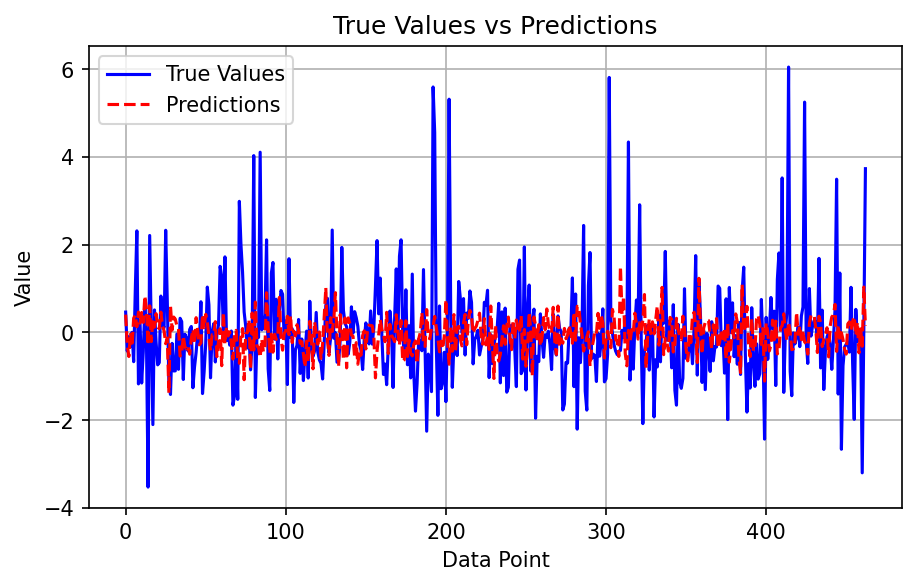

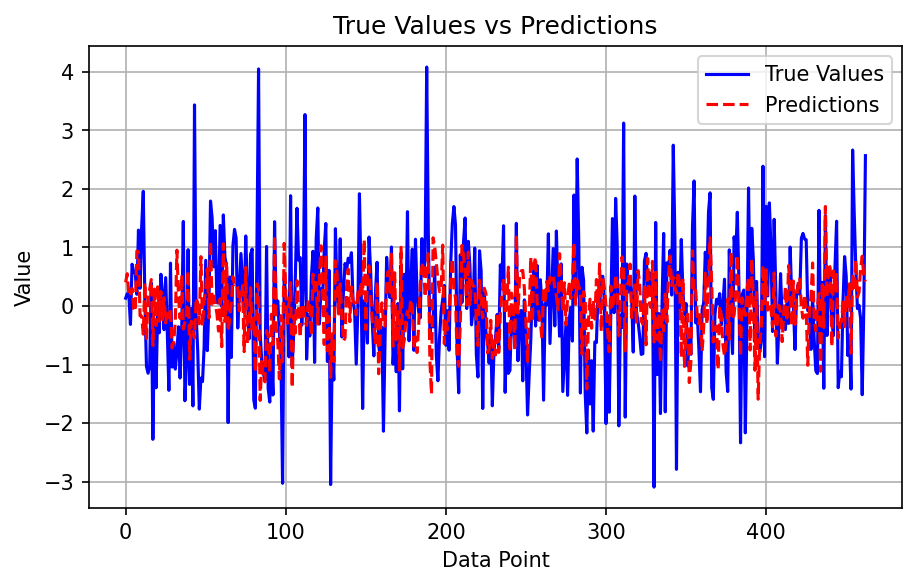

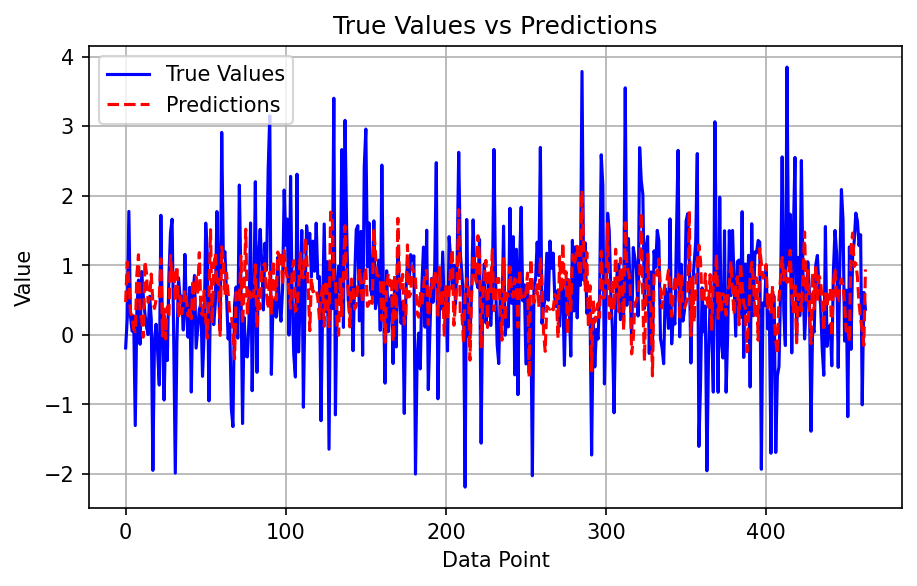

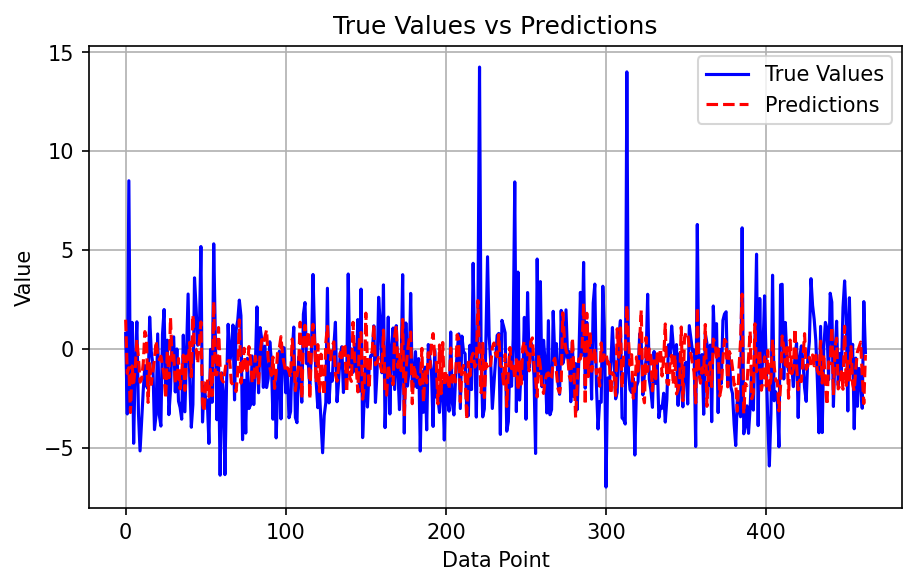

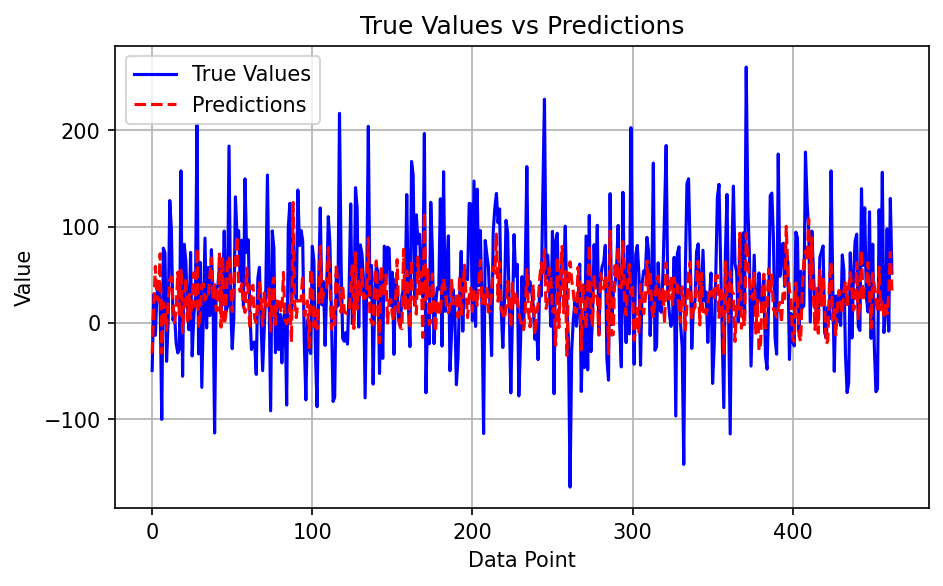

In [ ]:
def load_model(model_path):

    if torch.cuda.is_available():
        model = torch.load(model_path)
    else:
        model = torch.load(model_path, map_location=torch.device('cpu'))

    model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    return model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = load_model('model_cnn_pig_data.pth')
pre = []
for i in X_test:
    i = i.unsqueeze(0)
    pre.append(model(i.to(device)).cpu().detach().numpy())
pre = np.array(pre)
pre = np.squeeze(pre)
Y_test1 = Y_test.cpu().detach().numpy().copy()
for i in range(pre.shape[1]):
    pre[:,i] = pre[:,i]*Std[i] +Mean[i]
    Y_test1[:,i] = Y_test1[:,i]*Std[i] +Mean[i]
    plt.figure(dpi=150,figsize=(7,4))
    plt.plot(Y_test1[:,i], label='True Values', color='blue')
    plt.plot(pre[:,i], label='Predictions', linestyle='--', color='red')
    plt.title('True Values vs Predictions')
    plt.xlabel('Data Point')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.savefig('cnn_对比图_{}.jpg'.format(i),dpi=150)
    plt.show()

In [ ]:
def Evaluation_index(Y_test1,pre):
    from sklearn.metrics import r2_score, mean_squared_error,explained_variance_score,mean_absolute_error
    r2 = r2_score(Y_test1,pre)
    ev = explained_variance_score(Y_test1,pre)
    mse = mean_squared_error(Y_test1,pre)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Y_test1,pre)

    pre = pre.reshape(-1)
    Y_test1 = Y_test1.reshape(-1)
    INDEX = []
    page = 0
    for i in Y_test1:
        if i ==0:
            INDEX.append(page)
        page +=1
    if INDEX !=[]:
        Y_test1 = np.delete(Y_test1,INDEX,0)
        pre     = np.delete(pre,INDEX,0)
    mape = (sum(abs((pre - Y_test1)/(Y_test1)))/len(Y_test1))
    evaluation_index = pd.DataFrame()
    evaluation_index['评估指标名称'] = ['r2','ev','mse','rmse','mae','mape']
    evaluation_index['评估指标值'] = [r2,ev,mse,rmse,mae,mape]
    print('r2:',r2)
    print('ev:',ev)
    print('mse:',mse)
    print('rmse:',rmse)
    print('mae:',mae)
    print('mape:',mape)
    return evaluation_index
for i in range(pre.shape[1]):
    evaluation_index = Evaluation_index(Y_test1[:,i],pre[:,i])
    evaluation_index.to_csv(f'evaluation_index_pig_{i}.csv',index = False)
    print('-----------------')

r2: -0.11800777340764146
ev: -0.11768639087677002
mse: 1.5890038
rmse: 1.2605569
mae: 0.8706323
mape: 4.879170626623166
-----------------
r2: 0.17821478194347107
ev: 0.17830300331115723
mse: 0.95589525
rmse: 0.977699
mae: 0.7603477
mape: 12.751356238547308
-----------------
r2: 0.10055376473910638
ev: 0.10156446695327759
mse: 0.846854
rmse: 0.9202467
mae: 0.71685654
mape: 4.2715929516311535
-----------------
r2: 0.11265643963467142
ev: 0.11355733871459961
mse: 5.652154
rmse: 2.377426
mae: 1.7833481
mape: 2.47044367303586
-----------------
r2: 0.14039011994123052
ev: 0.16126424074172974
mse: 3544.2986
rmse: 59.53401
mae: 46.339222
mape: 1.785810133284883
-----------------


In [ ]:
evaluation_index = Evaluation_index(Y_test1,pre)

r2: 0.08276147270944496
ev: 0.08740060329437256
mse: 710.6685
rmse: 26.658367
mae: 10.094081
mape: 5.231674724624474
